# Train a PINN (Physics Informed Neural Network) with a custom PDE

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyLOM
from pyLOM import NN

from pathlib import Path

In [2]:
data_dir = Path.cwd().parent / 'data'

We will solve a Burgers equation:

$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu\frac{\partial^2u}{\partial x^2}, \qquad x \in [-1, 1], \quad t \in [0, 1]
$$


with the Dirichlet boundary conditions and initial conditions  

$$
u(-1,t)=u(1,t)=0, \quad u(x,0) = - \sin(\pi x)
$$

The reference solution is here: https://github.com/lululxvi/deepxde/blob/master/examples/dataset/Burgers.npz

## Define the collocation points

We define 256 points on x and 100 points on t. Then, 5000 points are chosen to train the PINN.


In [3]:
POINTS_ON_X = 256
POINTS_ON_T = 100
num_train_simulations = 5000
t = np.linspace(0, 1, POINTS_ON_T)
x = np.linspace(-1, 1, POINTS_ON_X)
T, X = np.meshgrid(t, x)

train_idx = np.random.choice(X.flatten().shape[0], num_train_simulations, replace=False)
TX = np.concatenate([T.reshape(-1, 1), X.reshape(-1, 1)], axis=1)
TX = torch.tensor(TX).float()
train_TX = TX[train_idx]

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Define the PDE
We could use here pyLOM.NN.BurgersPINN, but for demonstrations purposes, we define it here from scratch

In [5]:
class BurgersPINN(NN.PINN):
    def __init__(self, viscosity=0.01, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.viscosity = viscosity

    def pde_loss(self, pred, *input_variables):
        t, x = input_variables
        u = pred
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

        f = u_t + u * u_x - (self.viscosity / torch.pi) * u_xx

        return (f ** 2).mean()

## Define the boundary conditions

In [6]:
class InitialCondition(NN.BoundaryCondition):

    def loss(self, pred):
        x = self.points[:, 1].reshape(-1, 1)
        initial_cond_pred = pred
        # the sin is negative because the initial condition is u(0, x) = -sin(pi * x)
        ic_loss = (initial_cond_pred + torch.sin(torch.pi * x).to(device)) ** 2
        return ic_loss.mean()

    
class XBoudaryCondition(pyLOM.NN.BoundaryCondition):

    def loss(self, pred):
        # as u on the boundary is 0, we can just return the mean of the prediction
        return pred.pow(2).mean()


The points needed on each boundary condition are:  
* For the initial condition: The t coordinate must be 0 and the x coordinate should include all of the points on the x domain.  
* For the upper and lower boundary conditions: As we have 2 boundaries, there should be 2 tensors, one with x = -1 and t taking all the possible values on its domain and other one with x = 1. Then, both thensors are staked vertically. 

In [7]:
initial_points = torch.tensor(x).reshape(-1, 1)
initial_bc = InitialCondition(
    torch.cat([torch.full_like(initial_points, 0), initial_points], dim=-1).float(),
)

boundary_points = torch.tensor(t).reshape(-1, 1)
boundary_bc = XBoudaryCondition(
    torch.cat(
        [torch.cat([boundary_points, torch.full_like(boundary_points, -1)], dim=-1),
        torch.cat([boundary_points, torch.full_like(boundary_points, 1)], dim=-1),]
    ).float()
)

### Dataset creation
In this example, a PINN will be trained to learn the PDE just from the equation and some boundary conditions. A way to improve the accuracy of the model, is giving it simulation data on some points. This can be achieved creating datasets that has a value for that data as described on the next cell

Data available at: https://github.com/maziarraissi/PINNs/blob/master/appendix/Data/burgers_shock.mat

In [8]:
import scipy

data = scipy.io.loadmat(data_dir / 'burgers_shock.mat')

# To train the model with simulation data too, uncomment the following lines
# u_simulation = np.real(data['usol']).flatten().reshape(-1, 1)
# train_dataset = torch.utils.data.TorchDataset((train_TX, u_simulation[idx]))
# test_dataset = torch.utils.data.TorchDataset((TX, u_simulation))

train_dataset = torch.utils.data.TensorDataset(train_TX)
test_dataset = torch.utils.data.TensorDataset(TX)

In [9]:
train_dataset[:][0], train_TX.shape, (train_TX.shape[1],)

(tensor([[ 0.1414, -0.7647],
         [ 0.6162,  0.0667],
         [ 0.0909,  0.3020],
         ...,
         [ 0.8586,  0.8431],
         [ 0.8182, -0.7961],
         [ 0.8081, -0.9922]]),
 torch.Size([5000, 2]),
 (2,))

## Train the pinn

In [10]:
input_dim = TX.shape[1]
output_dim = 1 # u(t, x)

net = pyLOM.NN.MLP(
    input_size=input_dim,
    output_size=output_dim,
    hidden_size=40,
    n_layers=4,
    activation=torch.nn.functional.tanh, # With relu the model struggles to converge
)

burgers_pinn = BurgersPINN(
    viscosity=0.01,
    neural_net=net,
    device=device,
)

Epoch 1/3500 Iteration 0. Pde loss: 5.0355e-03, data/bc losses: [4.6883e-01, 2.9546e-02]
Epoch 1001/3500 Iteration 0. Pde loss: 4.1698e-02, data/bc losses: [5.2957e-02, 1.0568e-03], test loss: 9.6583e-02
Epoch 2001/3500 Iteration 0. Pde loss: 2.5476e-02, data/bc losses: [3.2416e-02, 4.1371e-04], test loss: 5.9507e-02
Epoch 3001/3500 Iteration 0. Pde loss: 1.4726e-02, data/bc losses: [1.5872e-02, 2.8335e-04], test loss: 3.6492e-02


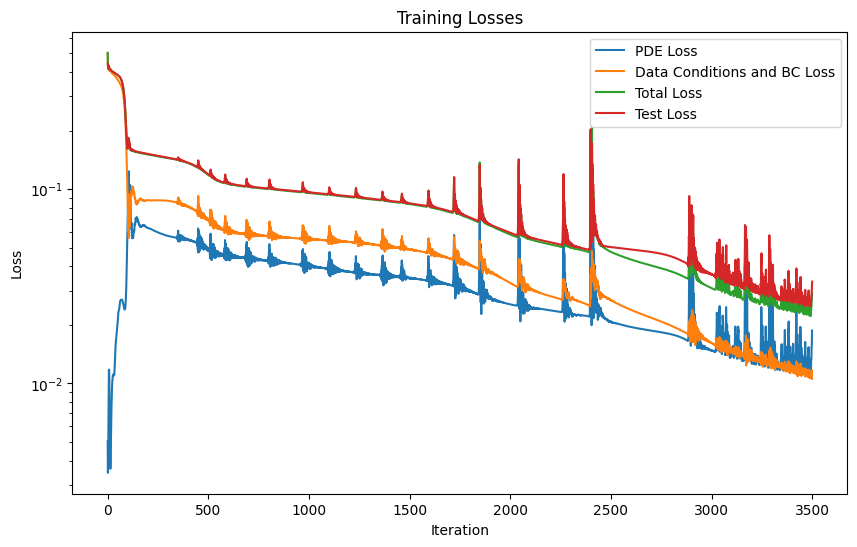

In [11]:
training_params = {
    'optimizer_class': torch.optim.Adam,
    'optimizer_params': {'lr': 1e-3},
    'epochs': 3500,
    'boundary_conditions': [initial_bc, boundary_bc],
    'update_logs_steps': 1000,
}

pipeline_adam = pyLOM.NN.Pipeline(
    model=burgers_pinn,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    training_params=training_params
)
model_logs = pipeline_adam.run()
burgers_pinn.plot_training_logs(model_logs)

### The model is retrained with an LBFGS optimizer to improve its acuraccy

Epoch 1/1 Iteration 0. Pde loss: 1.6910e-02, data/bc losses: [1.1646e-02, 3.3183e-04], test loss: 3.3384e-02
Epoch 1/1 Iteration 1. Pde loss: 1.5921e-02, data/bc losses: [1.1556e-02, 3.1618e-04], test loss: 3.3384e-02
Epoch 1/1 Iteration 2. Pde loss: 1.1179e-02, data/bc losses: [1.0831e-02, 2.2558e-04], test loss: 3.3384e-02
Epoch 1/1 Iteration 3. Pde loss: 1.1176e-02, data/bc losses: [1.0830e-02, 2.2544e-04], test loss: 3.3384e-02
Epoch 1/1 Iteration 4. Pde loss: 1.1166e-02, data/bc losses: [1.0824e-02, 2.2483e-04], test loss: 3.3384e-02
Epoch 1/1 Iteration 5. Pde loss: 1.1100e-02, data/bc losses: [1.0758e-02, 2.1868e-04], test loss: 3.3384e-02
Epoch 1/1 Iteration 6. Pde loss: 1.1100e-02, data/bc losses: [1.0757e-02, 2.1859e-04], test loss: 3.3384e-02
Epoch 1/1 Iteration 7. Pde loss: 1.1099e-02, data/bc losses: [1.0756e-02, 2.1831e-04], test loss: 3.3384e-02
Epoch 1/1 Iteration 8. Pde loss: 1.1095e-02, data/bc losses: [1.0745e-02, 2.1667e-04], test loss: 3.3384e-02
Epoch 1/1 Iteration

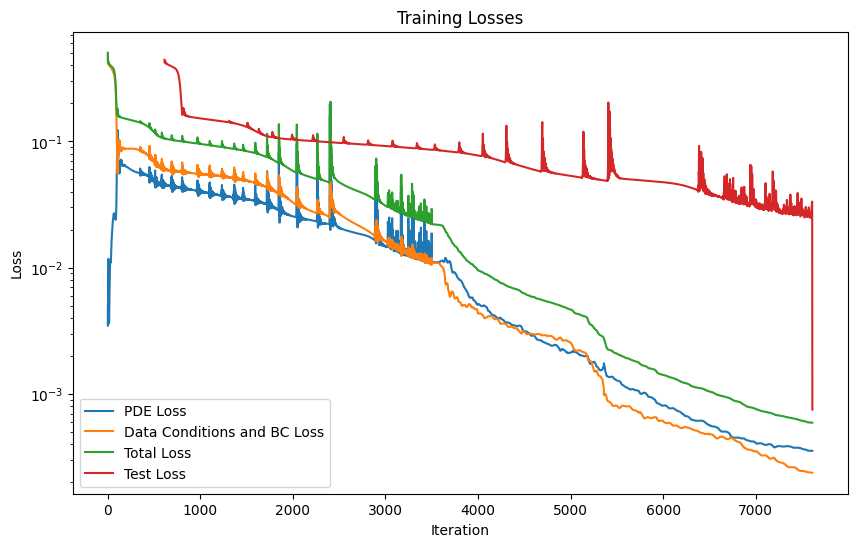

In [12]:
lbfgs_params = {
    'lr': 0.01,
    'max_iter': 12000,
    'max_eval': 10000,
    'history_size': 200,
    'tolerance_grad': 1e-12,
    'tolerance_change': 0.5 * np.finfo(float).eps,
    'line_search_fn': 'strong_wolfe'
}
training_params = {
    'optimizer_class': torch.optim.LBFGS,
    'optimizer_params': lbfgs_params,
    'loaded_logs': model_logs,
    'update_logs_steps': 1000,
    'epochs': 1,
    'boundary_conditions': [initial_bc, boundary_bc],
}

logs = pipeline_lbfgs = pyLOM.NN.Pipeline(
    model=burgers_pinn,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    training_params=training_params
)
model_logs = pipeline_lbfgs.run()
burgers_pinn.plot_training_logs(model_logs)

## Make the predictions and plot the results

In [13]:
u = burgers_pinn.predict(test_dataset).reshape(POINTS_ON_X, POINTS_ON_T)

In [14]:
u_ref = np.real(data['usol'])

### Evaluation using RegressionEvaluator

In [15]:
evaluator = NN.RegressionEvaluator()
evaluator(u.reshape(-1, 1), u_ref.reshape(-1, 1))
evaluator.print_metrics()


Regression evaluator metrics:
mse: 0.0060
rmse: 0.0777
mae: 0.0137
mre: 13.0021%
ae_95: 0.0347
ae_99: 0.1673
r2: 0.9839
l2_error: 0.1265


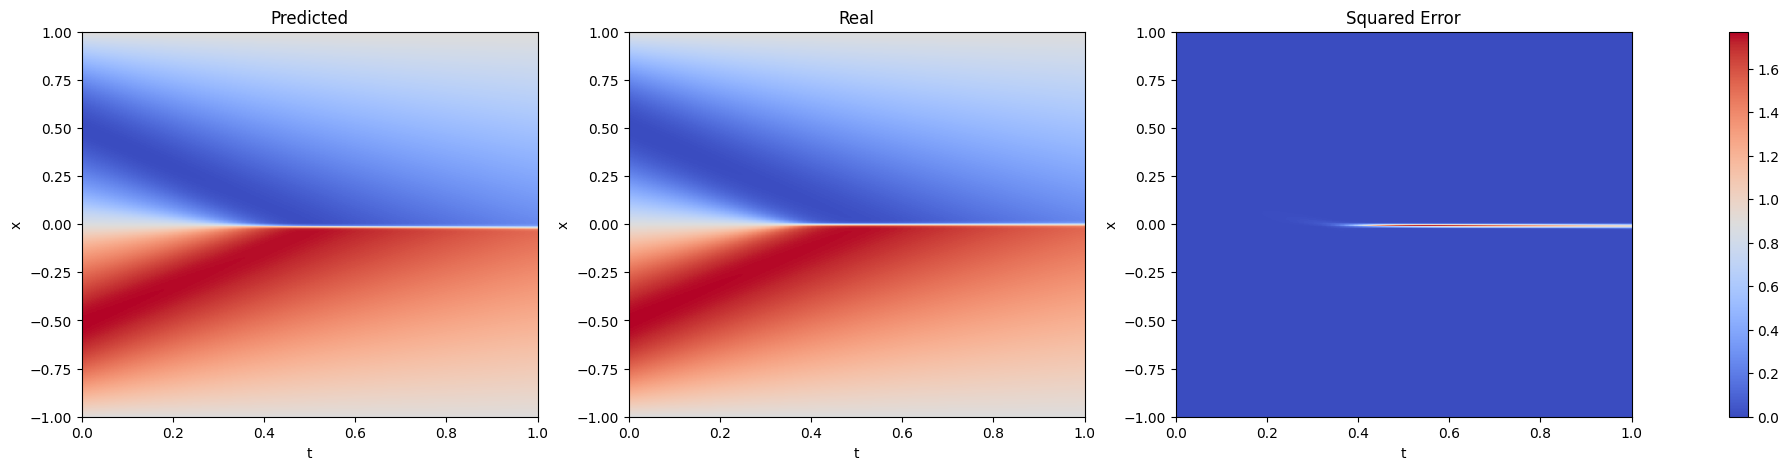

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(25, 5))
for i, (data, title) in enumerate(zip([u, u_ref, (u - u_ref) ** 2], ['Predicted', 'Real', 'Squared Error'])):
    im = axs[i].imshow(data, extent=[0, 1, -1, 1], origin='lower', aspect='0.25', cmap='coolwarm')
    axs[i].set_title(title)
    axs[i].set_xlabel('t')
    axs[i].set_ylabel('x')
    axs[i].set_aspect('auto')
    axs[i].grid(False)

fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

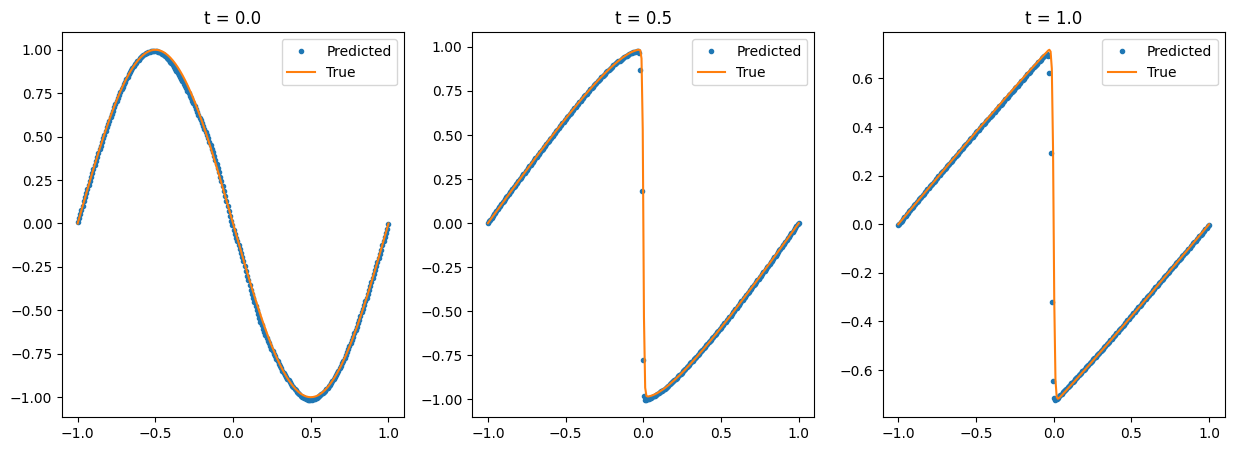

In [17]:
num_time_snapshots = 3
x = torch.linspace(-1, 1, 256).reshape(-1, 1)
fig, axs = plt.subplots(1, num_time_snapshots, figsize=(15, 5))
for i in range(num_time_snapshots):
    instant = i / (num_time_snapshots - 1)
    t = torch.full_like(x, instant)
    u_instant_t = burgers_pinn(torch.cat([t, x], dim=-1).to(device)).detach().cpu().numpy().reshape(-1)
    t_idx = int(np.round((u_ref.shape[1] - 1) * (i / (num_time_snapshots - 1))))

    u_true = u_ref[:, t_idx]
    axs[i].title.set_text(f"t = {instant}")
    axs[i].plot(x, u_instant_t, '.', label='Predicted')
    axs[i].plot(x, u_true, '-', label='True')
    axs[i].legend()

## Save and load the model

In [18]:
print("Saving model")
burgers_pinn.save('burgers_pinn.pt')
print("Model saved")
burgers_pinn_loaded = BurgersPINN.load('burgers_pinn.pt', device=device)
print("Model loaded")
predictions = burgers_pinn_loaded.predict(test_dataset)
print(f"Loss: {np.mean((predictions.reshape(-1, 1) - u_ref.reshape(-1, 1)) ** 2)}")

Saving model
Model saved
Model loaded
Loss: 0.006043060745997514
